[View in Colaboratory](https://colab.research.google.com/github/fearless23/google_ml_crash_course_notebooks/blob/master/Logistic_regression.ipynb)

# Logistic Regression

**Learning Objectives:**
  * Reframe the median house value predictor (from the preceding exercises) as a binary classification model
  * Compare the effectiveness of logisitic regression vs linear regression for a binary classification problem

As in the prior exercises, we're working with the [California housing data set](https://developers.google.com/machine-learning/crash-course/california-housing-data-description), but this time we will turn it into a binary classification problem by predicting whether a city block is a high-cost city block. We'll also revert to the default features, for now.

## Frame the Problem as Binary Classification

The target of our dataset is `median_house_value` which is a numeric (continuous-valued) feature. We can create a boolean label by applying a threshold to this continuous value.

Given features describing a city block, we wish to predict if it is a high-cost city block. To prepare the targets for train and eval data, we define a classification threshold of the 75%-ile for median house value (a value of approximately 265000). All house values above the threshold are labeled `1`, and all others are labeled `0`.

## Setup

Run the cells below to load the data and prepare the input features and targets.

In [0]:
from __future__ import print_function

import math

from IPython.display import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

Load Data and shuffle/randomize

In [0]:
dataset = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

dataset = dataset.reindex(np.random.permutation(dataset.index))

Instead of using `median_house_value` as target, we create a new binary target, median_house_value_is_high`.

In [0]:
def preprocess_x(dataset):
  selected_features = dataset[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  x = selected_features.copy()
  # Create a synthetic feature.
  x["rooms_per_person"] = (dataset["total_rooms"] / dataset["population"])
  return x

def preprocess_y(dataset):
  y = pd.DataFrame()
  # Create a boolean categorical feature representing whether the median_house_value is above a set threshold.
  y["median_house_value_is_high"] = ( dataset["median_house_value"] > 265000).astype(float)
  return y["median_house_value_is_high"]

In [0]:
# Choose the first 12000 (out of 17000) examples for training.
x_train = preprocess_x(dataset.head(12000))
y_train = preprocess_y(dataset.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
x_valid = preprocess_x(dataset.tail(5000))
y_valid = preprocess_y(dataset.tail(5000))

Double Check all train and validation data

In [0]:
print("x Train:")
display(x_train.describe())
display(x_train.head())

print("x Valid")
display(x_valid.describe())
display(x_valid.head())


print("y Train:")
display(y_train.describe())
display(y_train.head())

print("y valid:")
display(y_valid.describe())
display(y_valid.head())

## Step 1: Define Training Fn and other helper Functions

In [0]:
def construct_feature_columns(features):
  return set([tf.feature_column.numeric_column(feature) for feature in features])

In [0]:
def make_batches(x, y, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    x = {key:np.array(value) for key,value in dict(x).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((x,y)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    x, y = ds.make_one_shot_iterator().get_next()
    return x, y

In [0]:
def train_model(learning_rate,steps,batch_size,x_train,y_train,x_valid,y_valid):
  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  model = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(x_train),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  batches_train = lambda: make_batches(x_train,y_train, batch_size=batch_size)
  single_batch_train = lambda: make_batches(x_train, y_train,num_epochs=1,shuffle=False)
  single_batch_valid = lambda: make_batches(x_valid,y_valid,num_epochs=1,shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Model Training Started...")
  print("Loss (on training data):")
  
  # Loss is a general term, i.e rmse or log loss etc.
  loss_train_list = []
  loss_valid_list = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    model.train(input_fn=batches_train,  steps=steps_per_period)
    
    # Take a break and compute predictions.
    # Prediction can be probability in Linear Classifier
    y_train_p = model.predict(input_fn=single_batch_train)
    y_train_p = np.array([item['probabilities'][0] for item in y_train_p])
    
    y_valid_p = model.predict(input_fn=single_batch_valid)
    y_valid_p = np.array([item['probabilities'][0] for item in y_valid_p])
    
    # Compute training and validation loss.
    # rmse_train = math.sqrt( metrics.mean_squared_error(y_train_p, y_train))
    loss_train = metrics.log_loss(y_train, y_train_p)
    # rmse_valid = math.sqrt( metrics.mean_squared_error(y_valid_p, y_valid))
    loss_valid = metrics.log_loss(y_valid, y_valid_p)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, loss_train))
    # Add the loss metrics from this period to our list.
    loss_train_list.append(loss_train)
    loss_valid_list.append(loss_valid)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("Loss")
  plt.xlabel("Period")
  plt.title("Loss (Log Loss) vs. Periods")
  plt.tight_layout()
  plt.plot(loss_train_list, label="training")
  plt.plot(loss_valid_list, label="validation")
  plt.legend()

  return model

## Step 2: Run Training

Model Training Started...
Loss (on training data):
  period 00 : 0.78
  period 01 : 0.82
  period 02 : 0.82
  period 03 : 0.89
  period 04 : 0.97
  period 05 : 0.99
  period 06 : 1.00
  period 07 : 1.02
  period 08 : 1.00
  period 09 : 1.08
Model training finished.


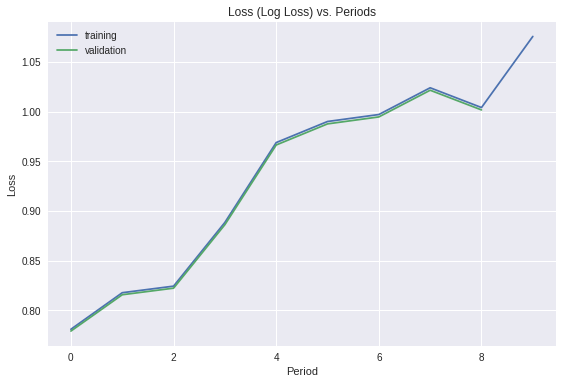

In [59]:
model = train_model( learning_rate=0.000001, steps=200, batch_size=20, x_train = x_train, y_train = y_train, x_valid = x_valid, y_valid = y_valid )

## Task: Calculate Accuracy and plot a ROC Curve for the Validation Set

Useful metrics for classification:
* [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification), 
* [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) 
* Area under the ROC curve (AUC)

`LinearClassifier.evaluate` calculates useful metrics like accuracy and AUC.

`LinearClassifier.predict`,  and Sklearn's [roc_curve](http://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) to
obtain the true positive and false positive rates needed to plot a ROC curve.

In [0]:
def cal_metrics(model):
  single_batch_valid = lambda: make_batches(x_valid,y_valid,num_epochs=1,shuffle=False)
    
  y_valid_p = model.predict(input_fn=single_batch_valid)
  # Get just the probabilities for the positive class.
  y_valid_p = np.array([item['probabilities'][1] for item in y_valid_p])
  
  print("ROC Curve")
  false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_valid, y_valid_p)
  plt.plot(false_positive_rate, true_positive_rate, label="our model")
  plt.plot([0, 1], [0, 1], label="random classifier")
  plt.ylabel("TPR")
  plt.xlabel("FPR")
  _ = plt.legend(loc=2)
        
  evaluation_metrics = model.evaluate(input_fn=single_batch_valid)

  print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
  print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])
  

ROC Curve
AUC on the validation set: 0.48
Accuracy on the validation set: 0.74


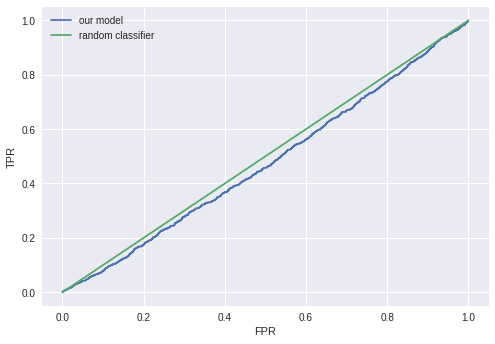

In [61]:
cal_metrics(model)

**See if you can tune the learning settings of the model trained at Task 2 to improve AUC.**

Often times, certain metrics improve at the detriment of others, and you'll need to find the settings that achieve a good compromise.

**Verify if all metrics improve at the same time.**

One possible solution that works is to just train for longer, as long as we don't overfit. 

We can do this by increasing the number the steps, the batch size, or both.

All metrics improve at the same time, so our loss metric is a good proxy
for both AUC and accuracy.

Notice how it takes many, many more iterations just to squeeze a few more 
units of AUC. This commonly happens. But often even this small gain is worth 
the costs.

Model Training Started...
Loss (on training data):
  period 00 : nan
  period 01 : nan
  period 02 : nan
  period 03 : nan
  period 04 : nan
  period 05 : nan
  period 06 : nan
  period 07 : nan
  period 08 : nan
  period 09 : nan
Model training finished.


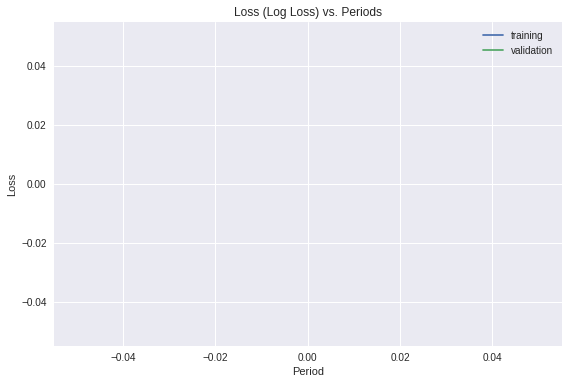

In [63]:
new_model = train_model( learning_rate=0.000003, steps=20000, batch_size=500, x_train = x_train, y_train = y_train, x_valid = x_valid, y_valid = y_valid )

ROC Curve
AUC on the validation set: 0.81
Accuracy on the validation set: 0.79


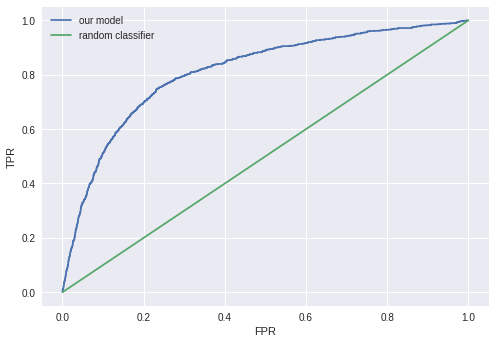

In [65]:
cal_metrics(new_model)